In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import xgboost as xgb
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [13]:
file_path = '/Users/yadhu/PROJECTS/cape-THERAPIST/datasets/archive (5)/val.txt'
val_df = pd.read_csv(file_path, sep=';', header=None, names=['Text', 'Emotion'])
file_path = '/Users/yadhu/PROJECTS/cape-THERAPIST/datasets/archive (5)/train.txt'
test_df = pd.read_csv(file_path, sep=';', header=None, names=['Text', 'Emotion'])
file_path = '/Users/yadhu/PROJECTS/cape-THERAPIST/datasets/archive (5)/test.txt'
train_df = pd.read_csv(file_path, sep=';', header=None, names=['Text', 'Emotion'])

train_df.info()
print('-----------------------------------------------------------------------')
test_df.info()
print('-----------------------------------------------------------------------')
val_df.info()

print(val_df['Emotion'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409 entries, 0 to 2408
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     2409 non-null   object
 1   Emotion  2409 non-null   object
dtypes: object(2)
memory usage: 37.8+ KB
-----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17355 entries, 0 to 17354
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     17355 non-null  object
 1   Emotion  17355 non-null  object
dtypes: object(2)
memory usage: 271.3+ KB
-----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2722 entries, 0 to 2721
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     2722 non-null   object
 1   Emotion  2722 non-null   object
dtypes: o

In [14]:
percentage_appearance = val_df['Emotion'].value_counts(normalize=True) * 100
print(percentage_appearance)
print('-----------------------------------------------------------------------')
percentage_appearance = train_df['Emotion'].value_counts(normalize=True) * 100
print(percentage_appearance)
print('-----------------------------------------------------------------------')
percentage_appearance = test_df['Emotion'].value_counts(normalize=True) * 100
print(percentage_appearance)


Emotion
joy            25.863336
sadness        20.205731
 depression    13.152094
 anxiety       12.894930
anger          10.102866
fear            7.788391
love            6.539309
surprise        2.975753
 fear           0.477590
Name: proportion, dtype: float64
-----------------------------------------------------------------------
Emotion
joy            28.850145
sadness        24.117891
anger          11.415525
fear            9.298464
 depression     8.800332
 anxiety        8.136156
love            6.600249
surprise        2.739726
 emotion        0.041511
Name: proportion, dtype: float64
-----------------------------------------------------------------------
Emotion
joy            30.895995
sadness        26.885624
anger          12.440219
fear           11.161049
love            7.513685
anxiety         3.422645
surprise        3.295880
depression      2.189571
 depression     1.100547
 anxiety        1.094785
Name: proportion, dtype: float64


In [15]:
val_df = val_df.drop(val_df[(val_df['Emotion'] == 'surprise') | (val_df['Emotion'] == 'love')].index)
test_df = test_df.drop(test_df[(test_df['Emotion'] == 'surprise') | (test_df['Emotion'] == 'love')].index)
train_df = train_df.drop(train_df[(train_df['Emotion'] == 'surprise') | (train_df['Emotion'] == 'love')].index)
print('------------------------- dropped columns ---------------------------------')
print(train_df['Emotion'].value_counts())

print('------------------------- dropped columns ---------------------------------')
print(test_df['Emotion'].value_counts())

print('------------------------- dropped columns ---------------------------------')
print(val_df['Emotion'].value_counts())


------------------------- dropped columns ---------------------------------
Emotion
joy            695
sadness        581
anger          275
fear           224
 depression    212
 anxiety       196
 emotion         1
Name: count, dtype: int64
------------------------- dropped columns ---------------------------------
Emotion
joy            5362
sadness        4666
anger          2159
fear           1937
anxiety         594
depression      380
 depression     191
 anxiety        190
Name: count, dtype: int64
------------------------- dropped columns ---------------------------------
Emotion
joy            704
sadness        550
 depression    358
 anxiety       351
anger          275
fear           212
 fear           13
Name: count, dtype: int64


In [16]:
val_df['text_length'] = val_df['Text'].apply(len)
idx_max_length = val_df['text_length'].idxmax()
emotion = val_df.loc[idx_max_length, 'Emotion']
txt = val_df.loc[idx_max_length, 'Text']
print('the text is: ' + txt)
print('the emotion is: ' + emotion)
print('------------------------------------------------------------------')
nltk.download('stopwords')
print(stopwords.words('english'))


the text is: i couldnt hellip even when it made my heart ache to simply look at you hellip because i loved you so much and i knew you would never return my feelings hellip and i couldnt bring myself to hate you for the idiotic stunt you pulled in the other room either though i do ask that you dont repeat it
the emotion is: sadness
------------------------------------------------------------------
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'fo

[nltk_data] Error loading stopwords: <urlopen error [Errno 54]
[nltk_data]     Connection reset by peer>


In [17]:
class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, lower=False, stem=False):
        self.lower = lower
        self.stem = stem
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def text_processing(text):
            processed_text = re.sub('[^a-zA-Z]', ' ', text) # remove any non-alphabet characters
            if self.lower:
                processed_text = processed_text.lower()
            processed_text = processed_text.split()
            if self.stem:
                ps = PorterStemmer()
                processed_text = [ps.stem(word) for word in processed_text if word not in set(stopwords.words('english'))]
            processed_text = ' '.join(processed_text)
            return processed_text
        
        return [text_processing(text) for text in X]


In [18]:
def plot_confusion_matrices(train_true, train_pred, val_true, val_pred, test_true, test_pred, labels):
    # Create confusion matrices
    train_conf_matrix = confusion_matrix(train_true, train_pred)
    val_conf_matrix = confusion_matrix(val_true, val_pred)
    test_conf_matrix = confusion_matrix(test_true, test_pred)

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Train Confusion Matrix
    sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title('Train Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    # Validation Confusion Matrix
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
    xticklabels=labels, yticklabels=labels, ax=axes[1])

    axes[1].set_title('Validation Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True') 

    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=labels, yticklabels=labels, ax=axes[2])
    axes[2].set_title('Test Confusion Matrix')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')

    plt.tight_layout()
    plt.show() 
    


--------------------- Random Forest Classifier -------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Train set accuracy: 1.0
Validation set accuracy: 0.5988631749898498


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


Test set accuracy: 0.5392467213644292
0           sadness
1           sadness
3             anger
4               joy
5               joy
           ...     
2717        anxiety
2718     depression
2719        anxiety
2720     depression
2721        anxiety
Name: Emotion, Length: 2463, dtype: object
<class 'pandas.core.series.Series'>


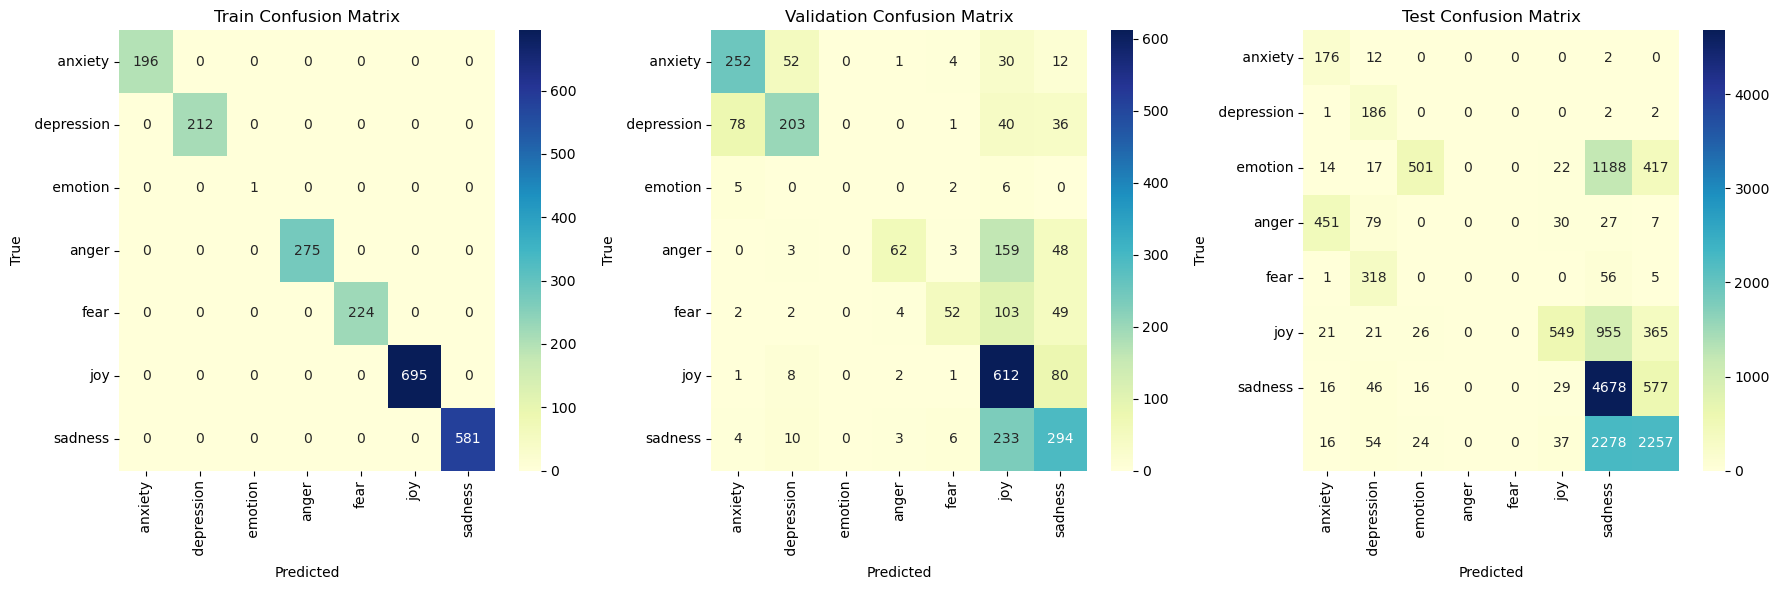

In [19]:
print('--------------------- Random Forest Classifier -------------------------------')
from sklearn.ensemble import RandomForestClassifier


text_processor = TextProcessor(lower=True, stem=False)
vectorizer = CountVectorizer(max_features=3000)
RF = RandomForestClassifier(
    n_estimators=50, random_state=42, n_jobs=-1, verbose=1
)

pipeline = Pipeline([
    ("text_processing", text_processor), # Text processing step
    ("vectorizer", CountVectorizer()),   # CountVectorizer step
    ("classifier", RF)  # RandomForestClassifier step
])

pipeline.fit(train_df['Text'], train_df['Emotion'])  

process_pip = Pipeline(
    [
        ("text_processing", text_processor),
    ]
)
x_train_procceced = process_pip.fit_transform(train_df['Text'])
x_test_procceced = process_pip.transform(test_df['Text'])
x_val_procceced = process_pip.transform(val_df['Text'])


train_pred = pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)
print(val_df['Emotion'] )
print(type(val_df['Emotion']))


RF_acc = test_accuracy



plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Train set accuracy: 1.0
Validation set accuracy: 0.5988631749898498


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


Test set accuracy: 0.5392467213644292


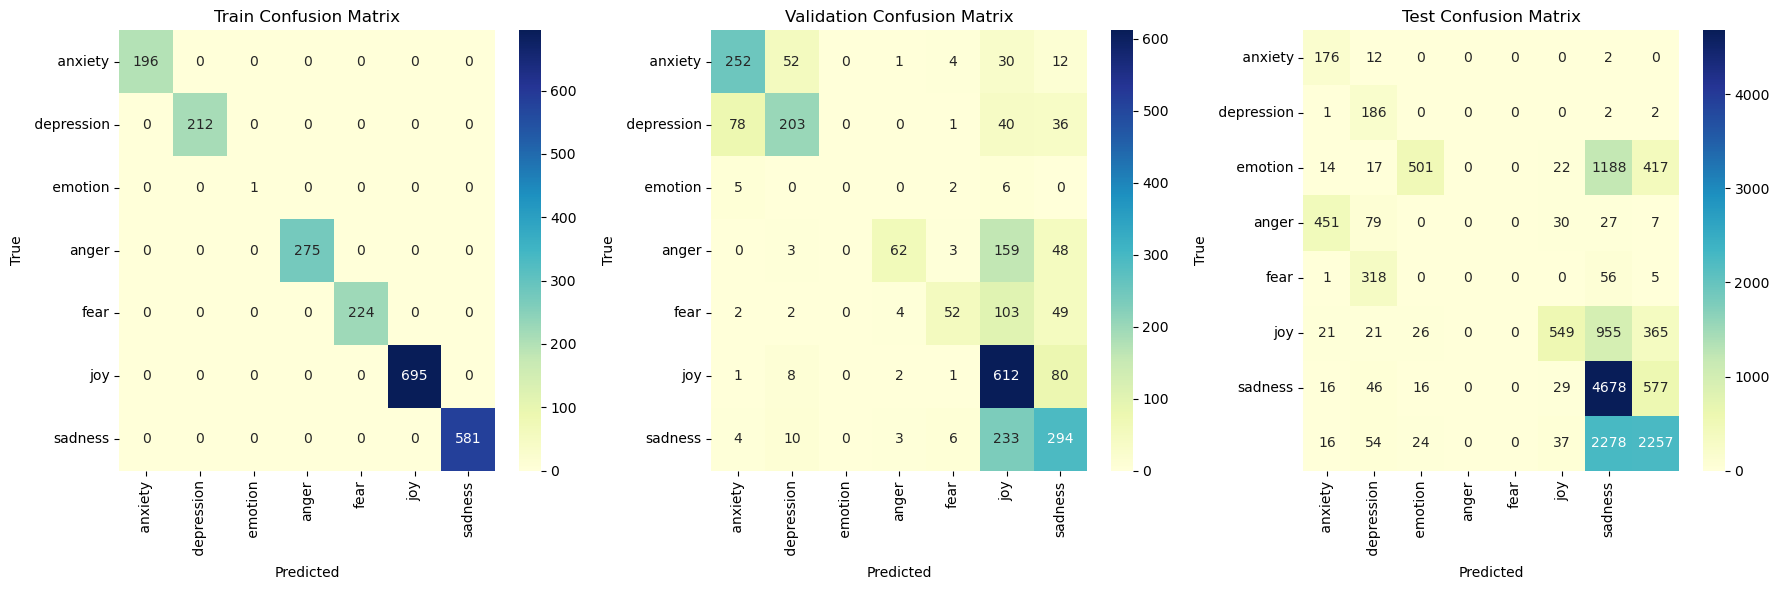

In [20]:
x_train_procceced = process_pip.fit_transform(train_df['Text'])
x_test_procceced = process_pip.transform(test_df['Text'])
x_val_procceced = process_pip.transform(val_df['Text'])


train_pred = pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

RF_acc = test_accuracy

plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

---------------------------- SVC -----------------------------------
Train set accuracy: 0.9958791208791209
Validation set accuracy: 0.7600487210718636
Test set accuracy: 0.7359002519542606


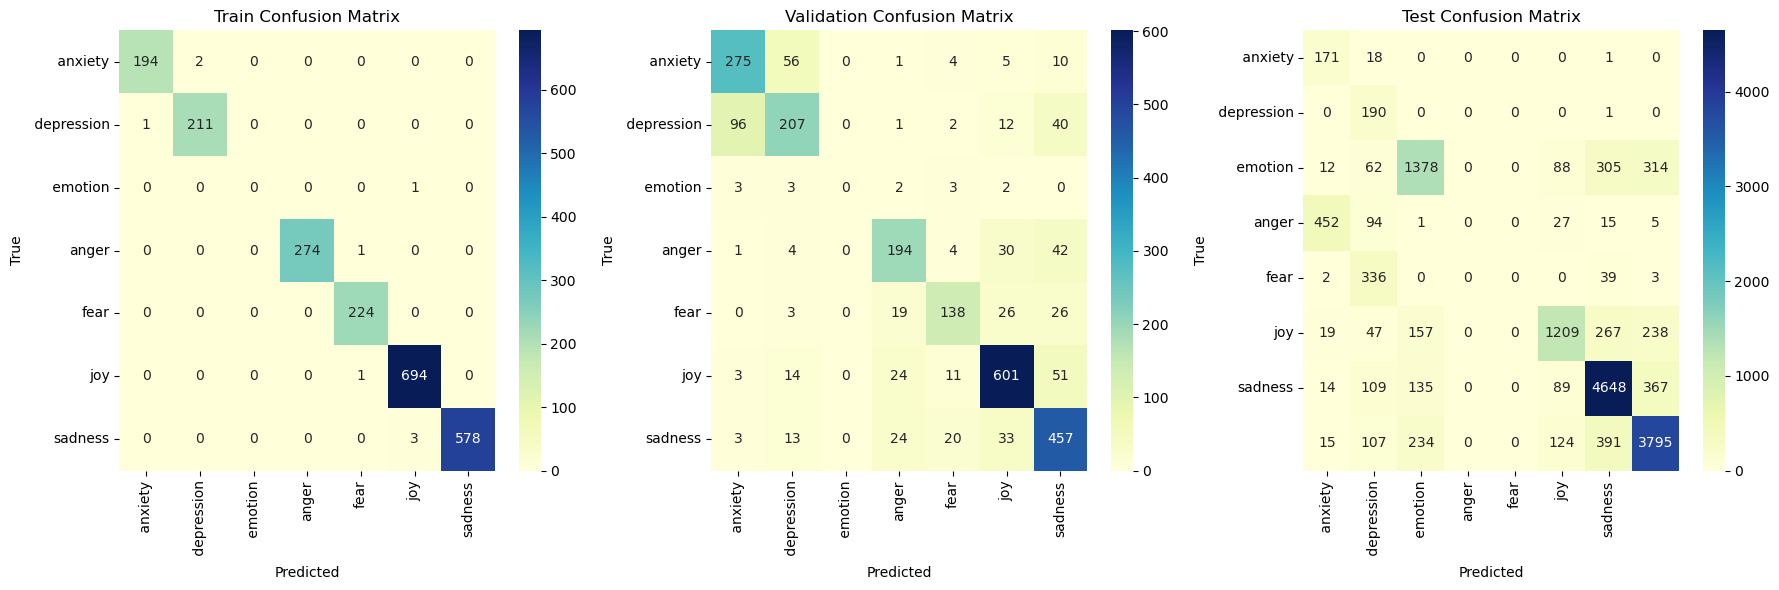

In [21]:
print('---------------------------- SVC -----------------------------------')

from sklearn.svm import SVC
text_processor = TextProcessor(lower=True, stem=False)
vectorizer = CountVectorizer(max_features=3000)
svm = SVC(kernel="linear",gamma=1, C=.5, random_state=42)
svm_pipeline = Pipeline(
    [
        ("text_processing", text_processor),
        ("vectorizer", vectorizer),
        ("svm", svm),
    ]
)
svm_pipeline.fit(train_df['Text'], train_df['Emotion']) 

train_pred = svm_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = svm_pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = svm_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

svm_acc= test_accuracy

plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

--------------------------- Logistic Regression ---------------------------
Train set accuracy: 0.9963369963369964
Validation set accuracy: 0.7287860332927324
Test set accuracy: 0.7069578138122617


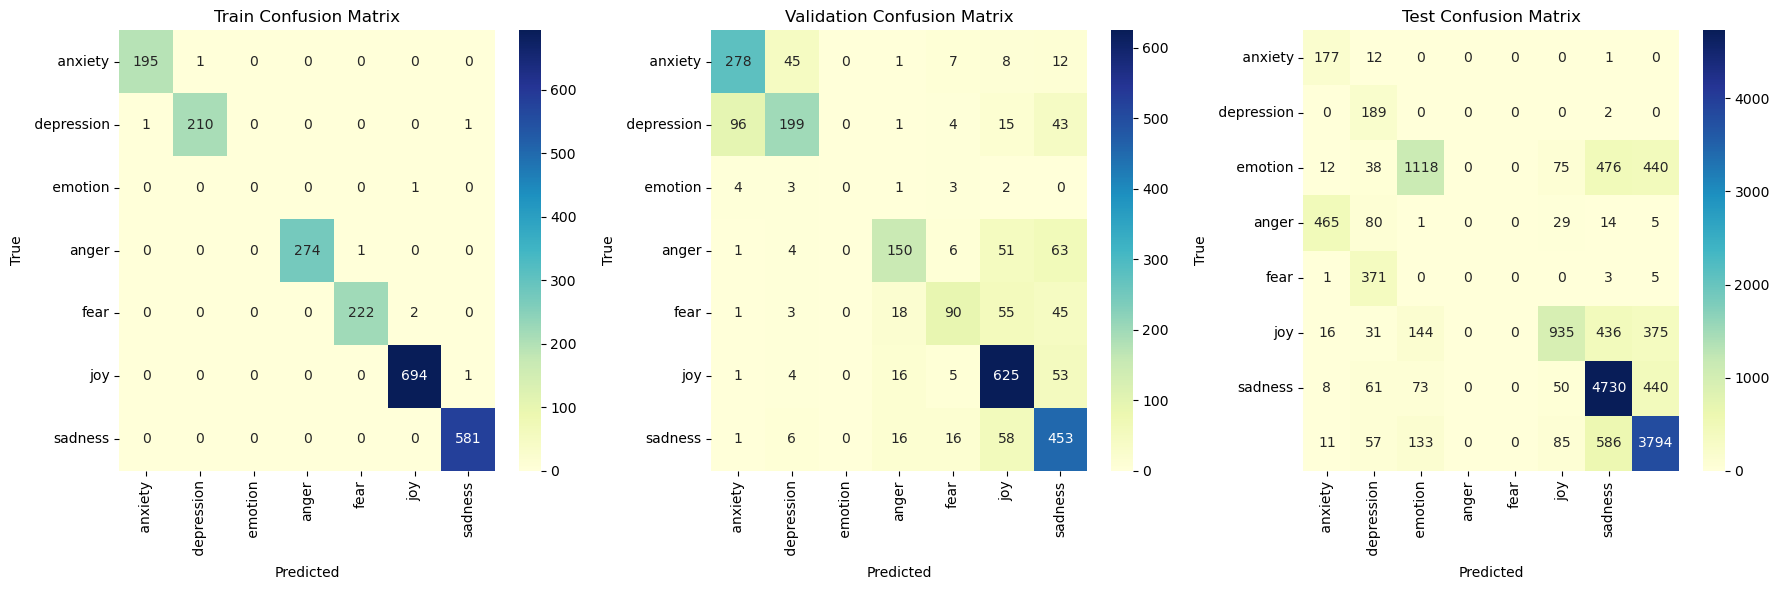

In [22]:
print('--------------------------- Logistic Regression ---------------------------')
from sklearn.linear_model import LogisticRegression
text_processor = TextProcessor(lower=True, stem=False)

vectorizer = CountVectorizer(max_features=3000)

logistics = LogisticRegression(random_state=42, max_iter=1000)

logs_pipeline = Pipeline([
    ("text_processing", text_processor), # Text processing step
    ("vectorizer", CountVectorizer()),   # CountVectorizer step
    ("classifier", logistics)  # RandomForestClassifier step
])

logs_pipeline.fit(train_df['Text'], train_df['Emotion'])

train_pred = logs_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = logs_pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = logs_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

logs_acc = test_accuracy

plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

---------------------------- MultiNomial NB ------------------------------------
Train set accuracy: 0.9308608058608059
Validation set accuracy: 0.682095006090134
Test set accuracy: 0.6588280896698753


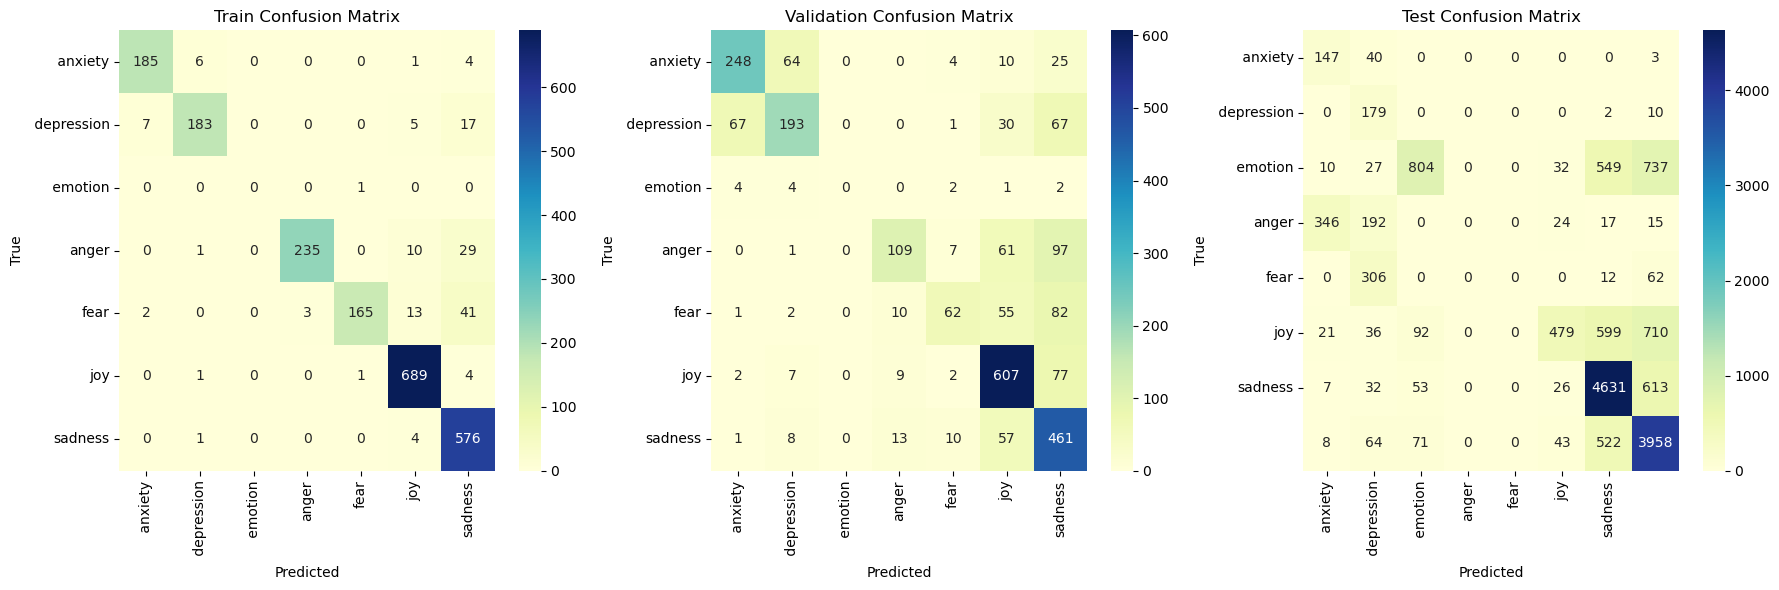

In [23]:
print('---------------------------- MultiNomial NB ------------------------------------')
from sklearn.naive_bayes import MultinomialNB
text_processor = TextProcessor(lower=True, stem=True)

vectorizer = CountVectorizer(max_features=3000)

MNB = MultinomialNB()

MNB_pipeline = Pipeline([
    ("text_processing", text_processor), # Text processing step
    ("vectorizer", CountVectorizer()),   # CountVectorizer step
    ("classifier", MNB)  # RandomForestClassifier step
])

MNB_pipeline.fit(train_df['Text'], train_df['Emotion'])

train_pred = MNB_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = MNB_pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = MNB_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

MNB_acc = test_accuracy

plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,    
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

----------------------------- Gradient Boosting Classifier ------------------------------
Train set accuracy: 0.9024725274725275
Validation set accuracy: 0.7202598457166057
Test set accuracy: 0.7258866851863816


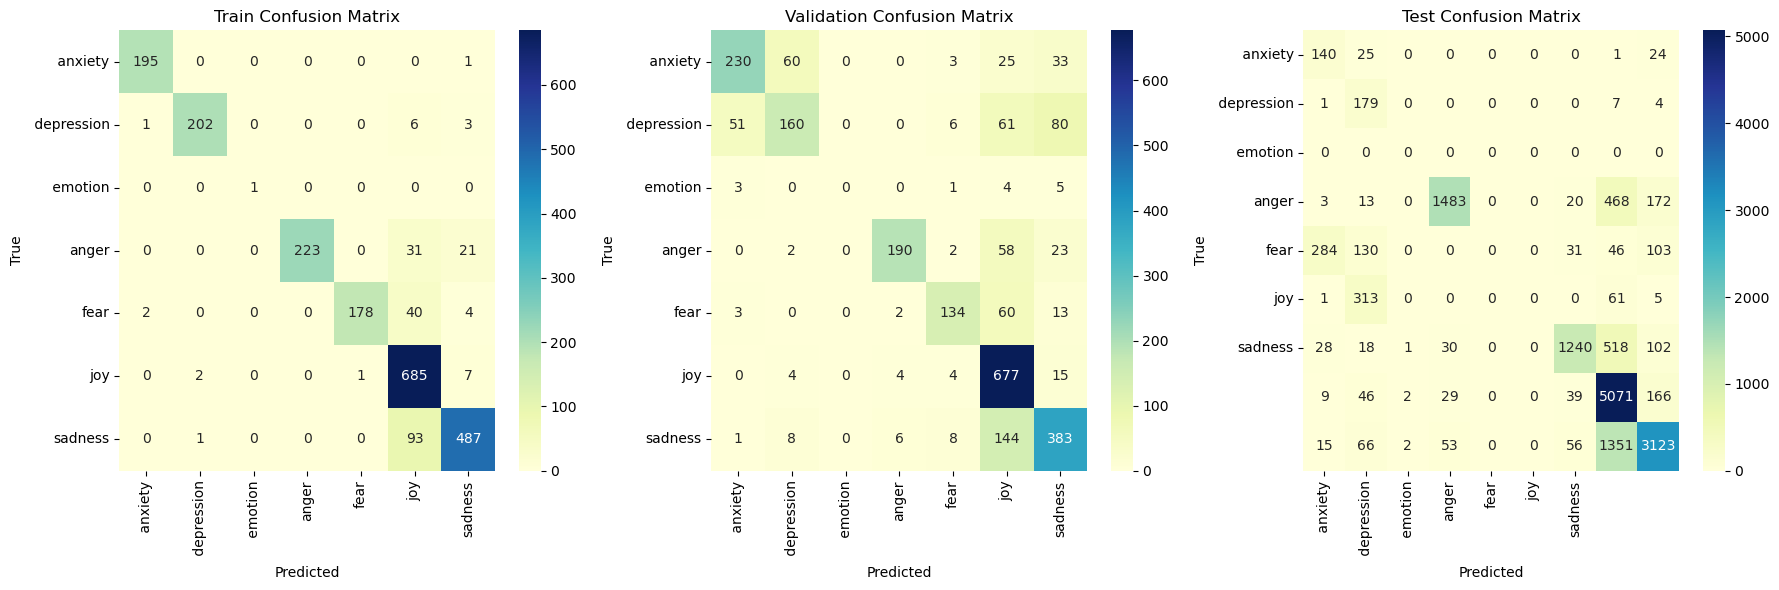

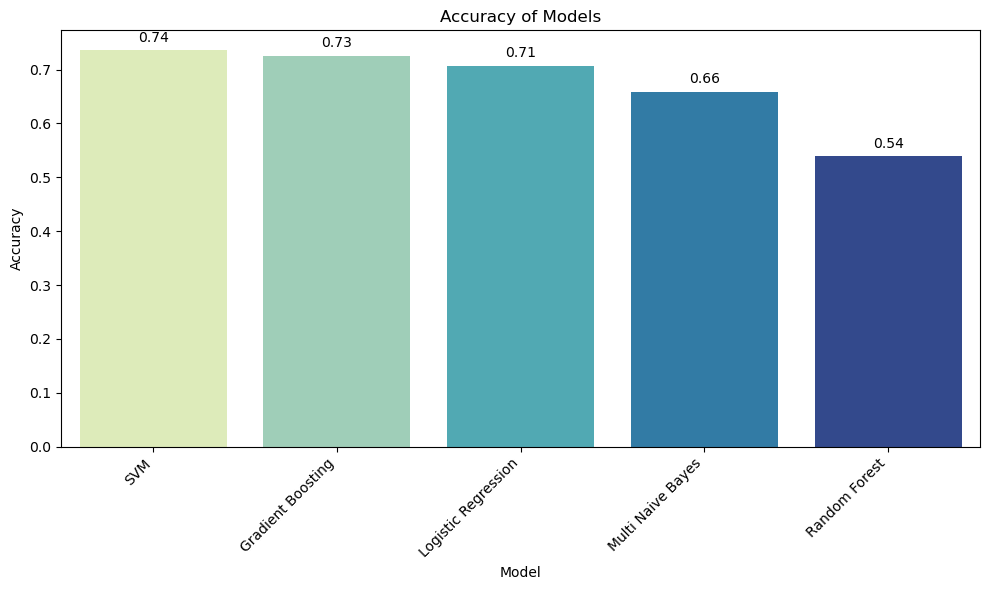

In [24]:
print('----------------------------- Gradient Boosting Classifier ------------------------------')
from sklearn.ensemble import GradientBoostingClassifier
text_processor = TextProcessor(lower=True, stem=False)

vectorizer = CountVectorizer(max_features=3000)

GB = GradientBoostingClassifier()

GB_pipeline = Pipeline([
    ("text_processing", text_processor), # Text processing step
    ("vectorizer", CountVectorizer()),   # CountVectorizer step
    ("classifier", GB)  # RandomForestClassifier step
])

GB_pipeline.fit(train_df['Text'], train_df['Emotion'])

train_pred = GB_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = GB_pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = GB_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

GB_acc = test_accuracy


plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

accuracies = {
    "Multi Naive Bayes": MNB_acc,
    "SVM": svm_acc,
    "Random Forest": RF_acc,
    "Logistic Regression": logs_acc,
    "Gradient Boosting": GB_acc
}

# Sort accuracies in descending order
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Extract model names and accuracies
model_names = [model[0] for model in sorted_accuracies]
accuracy_values = [model[1] for model in sorted_accuracies]
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=model_names, y=accuracy_values, palette="YlGnBu")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of Models")
plt.xticks(rotation=45, ha='right')

# Annotate each bar with its accuracy value
for i, v in enumerate(accuracy_values):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [25]:
print('-------------------- voting classifier ----------------------')
from sklearn.ensemble import VotingClassifier

estimators=[
        ("RFC", pipeline),
        ("Logistics Regression", logs_pipeline),
        ("Gradient Boosting",GB_pipeline),
        ("SVM", svm_pipeline)]


voting_classifier = VotingClassifier(estimators, voting='hard')
voting_classifier.fit(train_df['Text'], train_df['Emotion'])

train_pred = voting_classifier.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = voting_classifier.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = voting_classifier.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

model_accuracy = test_accuracy

-------------------- voting classifier ----------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


Train set accuracy: 0.9972527472527473


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


Validation set accuracy: 0.7624847746650426


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


Test set accuracy: 0.7181342463983461


In [30]:
print('---------------------- Model Accuracy -----------------------')

print('Our Machine Learning model has an accuracy of {:.2f}%'.format(model_accuracy * 100))

custom_text = "it feels like my career is slipping away from me and i don’t know how to fix it"
predicted_emotion = voting_classifier.predict([custom_text])
print("Predicted Emotion:", predicted_emotion[0])

custom_text = "I dont want this life"
predicted_emotion = voting_classifier.predict([custom_text])
print("Predicted Emotion:", predicted_emotion[0])

---------------------- Model Accuracy -----------------------
Our Machine Learning model has an accuracy of 71.81%
Predicted Emotion:  depression
Predicted Emotion: joy


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
